In [2]:
# 482 Assignment 1,  Part 1
# Authors: Martin Cruz & Will Eldridge
'''PART1 : 1.1 Sensor models'''
""" IR3  sensor model """
# Modules needed 

# %matplotlib notebook 
%matplotlib inline

import numpy as np
import time
import array
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
import os
import warnings
from numpy import *
from matplotlib.pyplot import subplots, show
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


# Load data
filename = 'calibration.csv'
data = np.loadtxt(filename, delimiter=',', skiprows=1)

# Split into columns
index, time, distance, velocity_command, raw_ir1, raw_ir2, raw_ir3, raw_ir4, \
    sonar1, sonar2 = data.T


# Sonar Sensor Sharp GP2Y0A02YK0F(0.15-1.5m)
## least squares solution
A_ir3 = np.vstack([distance, np.ones(len(raw_ir3))]).T
m_ir3, c_ir3 = np.linalg.lstsq(A_ir3, raw_ir3, rcond=None)[0]

# Second order polynomial fit
p2_ir3=polyfit(distance,raw_ir3,2)

#Robust Linear Regression
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

[0.32518459]
[0.00259086]


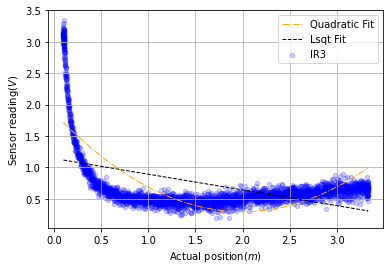

In [3]:


y2=raw_ir3
X2 = 1/distance
resrlm2 = sm.RLM(y2, X2).fit() # robust linear model
rlm2_fit= resrlm2.fittedvalues
m =resrlm2.params
c = resrlm2.bse
print(m)
print(c)

# data plot
plt.figure()

cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (20*cm,12*cm) #fig size in cm
plt.scatter(distance,raw_ir3, s=20 ,color='blue',label = 'IR3',alpha=0.2)

plt.plot(distance, (polyval(p2_ir3,distance)),'-.',linewidth=1, \
         color='orange', label='Quadratic Fit')
plt.plot(distance, ((m_ir3*distance) + c_ir3),'--',linewidth=1, \
         color='black', label='Lsqt Fit')

plt.xlabel('Actual position($m$)')#label graph
plt.ylabel('Sensor reading($V$)')
plt.grid(True)
plt.legend()
show()




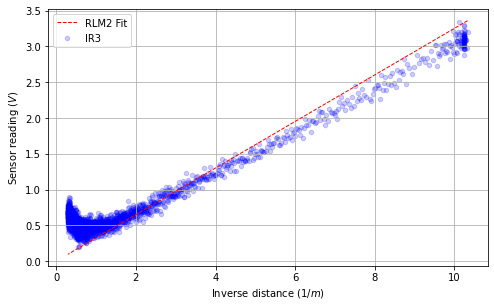

In [4]:
# data plot Reciprocal
plt.figure()
plt.rcParams["figure.figsize"] = (20*cm,12*cm) #fig size in cm
plt.scatter(1/distance,raw_ir3, s=20 ,color='blue',label = 'IR3',alpha=0.2)
plt.plot(1/distance, rlm2_fit,'--',linewidth=1, color='red', label='RLM2 Fit')

plt.xlabel('Inverse distance ($1/m$)')#label graph
plt.ylabel('Sensor reading $(V)$')
plt.grid(True)
plt.legend()
show()


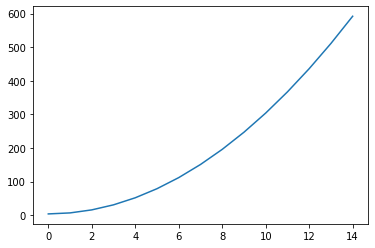

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
x = np.arange(0, 15)
y = 3 *x**2 + 4
plt.plot(x, y)

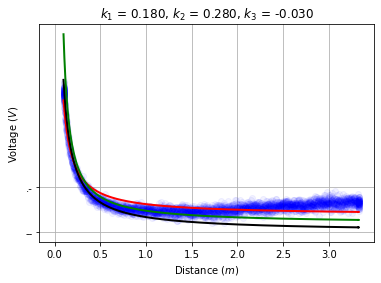

In [6]:
from numpy import loadtxt, ones, zeros, linspace
from numpy.linalg import lstsq
from matplotlib.pyplot import figure, show, savefig

def model_1(r, k):
    return k[0] + (k[1] / (r + k[2]))

def model_nonlinear_least_squares_fit(r, v, iterations=10000):

    N = len(r)
    A = ones((N, 3))
    k = [0, 0, 0]

    for i in range(iterations):
    # Calculate Jacobians for current estimate of parameters.
        for n in range(N):
            A[n, 1] = 1 / (r[n] + k[2])
            A[n, 2] = -k[1] / (r[n] + k[2])**2

            # Use least squares to estimate the parameters.
            deltak, res, rank, s = lstsq(A, v - model_1(r, k),rcond=-1)
            k += deltak
            # print(k)
        return k
r = distance
v = raw_ir3

# k = model_nonlinear_least_squares_fit(r, v)

k_lsq= [0.368, 0.246, 0.0]

k_rlm= [resrlm2.bse, resrlm2.params, 0.0]

k_manually= [0.18, 0.28, -0.03]

v1 = model_1(r, k_lsq)
v2 = model_1(r, k_rlm)
v3 = model_1(r, k_manually)

fig = figure()
ax = fig.add_subplot(111)
ax.plot(r, v, 'bo', '--',alpha=0.05)
ax.plot(r, v1, 'red','--', linewidth=2)
ax.plot(r, v2, 'k', linewidth=2) # rlm 
ax.plot(r, v3, 'green', '.-', linewidth=2)#manually placed 

ax.set_xlabel('Distance $(m)$')
ax.set_ylabel('Voltage $(V)$')

ax.set_title('$k_1$ = %.3f, $k_2$ = %.3f, $k_3$ = %.3f' % (k_manually[0], k_manually[1], k_manually[2]))
ax.grid(True)



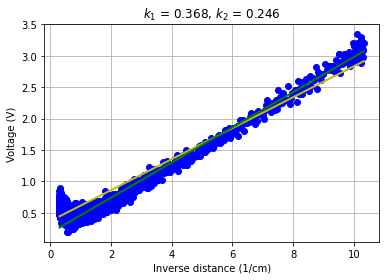

In [7]:
from numpy import loadtxt, ones, zeros, linspace
from numpy.linalg import lstsq
from matplotlib.pyplot import figure, show, savefig
def model_2(r, k):
    return k[0] + k[1] / r

def calculate_A(r):
    N = len(r)
    A = ones((N, 2))
    A[:, 1] = 1.0 / r
    return A

def model_least_squares_fit(r, v):
    A = calculate_A(r)
     # Use least squares to estimate the parameters.
    k, res, rank, s = lstsq(A, v, rcond=-1)
    return k

r = distance
v = raw_ir3
k = model_least_squares_fit(r, v)

v1 = model_2(r, k)
v2 = model_2(r, k_manually[0:2])

fig = figure()
ax = fig.add_subplot(111)
ax.plot(1.0 / r, v, 'bo')
ax.plot(1.0 / r, v1, 'y', linewidth=2)
ax.plot(1.0 / r, v2, 'g', linewidth=2)
ax.set_xlabel('Inverse distance (1/cm)')
ax.set_ylabel('Voltage (V)')
ax.set_title('$k_1$ = %.3f, $k_2$ = %.3f' % (k[0], k[1]))
ax.grid(True)

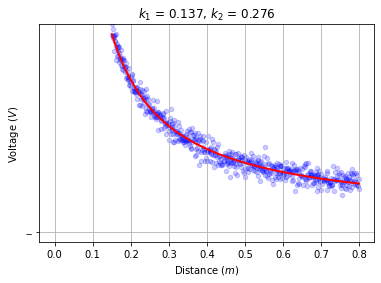

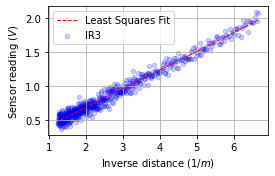

In [8]:
""" Decimation of data by the sensor specification"""
""" (0.15-0.8m) selected due to noise"""
# Data processing 
up_lim = np.float64(0.8) # choose upper limit
low_lim = np.float64(0.15) # choose lower

ir3_dec= [] #voltage array
r_ir3_dec= [] #range array
t_ir3_dec= [] #timeline array

ir3_dec = np.array(ir3_dec, dtype = np.float64)#array to arr of floats
r_ir3_dec = np.array(r_ir3_dec, dtype = np.float64)
t_ir3_dec = np.array(t_ir3_dec, dtype = np.float64)

for i in range(0,len(distance)):
    if(distance[i]>=low_lim and distance[i]<=up_lim):
        ir3_dec=np.append(ir3_dec, raw_ir3[i])#store in velocity array
        r_ir3_dec=np.append(r_ir3_dec, distance[i])#store in velocity array
        t_ir3_dec=np.append(t_ir3_dec, time[i])#store in velocity array
        
k_ir3_dec = model_least_squares_fit(r_ir3_dec, ir3_dec)

v_lsqt = model_2(r_ir3_dec, k_ir3_dec)

fig = figure()
plt.rcParams["figure.figsize"] = (10*cm,6*cm) #fig size in cm
plt.scatter(r_ir3_dec, ir3_dec,s=20,color="blue", alpha=0.2)
plt.plot(r_ir3_dec, v_lsqt, 'red','--', linewidth=2)

plt.xlabel('Distance $(m)$')
plt.ylabel('Voltage $(V)$')

plt.title('$k_1$ = %.3f, $k_2$ = %.3f' % (k_ir3_dec[0], k_ir3_dec[1]))
plt.grid(True)
show()

# data plot Reciprocal
plt.figure()
cm = 1/2.54  # centimeters in inches
plt.rcParams["figure.figsize"] = (10*cm,6*cm) #fig size in cm

plt.scatter((1/r_ir3_dec),ir3_dec,s=20,color='blue',label = 'IR3',alpha=0.2)

plt.plot(1/r_ir3_dec, v_lsqt,'--',linewidth=1, \
         color='red', label='Least Squares Fit')

plt.xlabel('Inverse distance ($1/m$)')#label graph
plt.ylabel('Sensor reading $(V)$')
plt.grid(True)
plt.legend()
show()

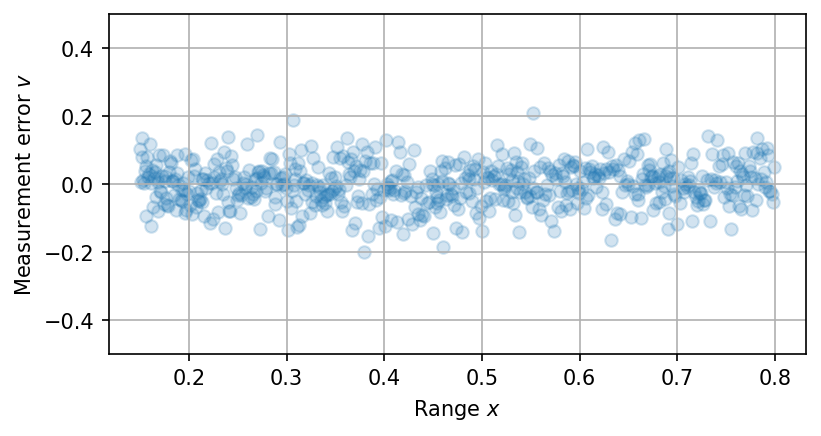

In [9]:
""" Decimation of outliers by a using a reference 
    variance Threeshold in the error function"""


err_ir3 = ir3_dec - v_lsqt #error function v()
# decimation of outliers by v()
'''Decimated data error Plot'''
plt.figure(figsize=(6, 3), dpi=150)
plt.scatter(r_ir3_dec,err_ir3,alpha = 0.2)
plt.grid()
plt.ylim(bottom=-0.5, top=0.5)
plt.xlabel('Range $x$')
plt.ylabel('Measurement error $v$')
show()


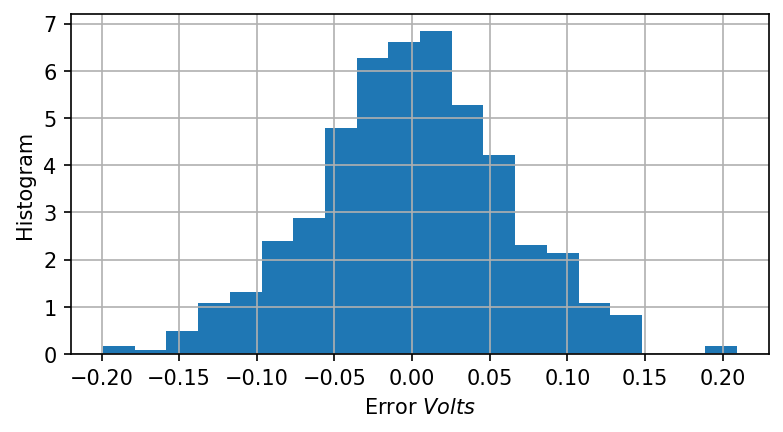

In [11]:
"""Histogram"""
plt.figure(figsize=(6, 3), dpi=150)
plt.hist(err_ir3, bins=20, density=True)
plt.grid()
plt.xlabel('Error $Volts$')
plt.ylabel('Histogram')

fig.tight_layout()
show()


In [1]:
"""Gaussian distribution"""
import scipy.stats as stats
import math
from sklearn import metrics
# Standard Deviacion  and 
std_err_ir3 = np.std(err_ir3)# Standard Deviacion 
var_err_ir3 = std_err_ir3**2 #variance
mean_err_ir3 = 0 # mean error

x_ir3 = np.linspace(mean_err_ir3 - 4*std_err_ir3, mean_err_ir3 + 4*std_err_ir3, 100)

plt.figure(figsize=(6, 3), dpi=150)
plt.plot(x_ir3, stats.norm.pdf(x_ir3, mean_err_ir3, std_err_ir3))
plt.ylabel('gaussian distribution')
plt.grid()
plt.show() 

print(var_err_ir3)



NameError: name 'np' is not defined